In this notebook we will look at linear regression problem. Recall linear regression it to find $\theta$ such that 
$$
h(x,\theta) = \theta_0 + \theta_1x_1+\ldots+\theta_Dx_D
$$
is a good predictor for training set $(x^{(i)}, y^{(i)})_{i=1}^m$ i.e we want to find $\theta$ that minimize
$$
J(\theta) = \frac{1}{2}\sum_{i=1}^m \left(h(x^{(i)}, \theta)- y^{(i)}\right)^2
$$
where $J(\theta)$ is also call the **least-square** loss function.


## Probabilistic interpretation: Maximum-likelihood
In this part, we try to understand why we use the linear representation with the **least-square** error. Let's asssume the target and inputs are related via the equation
$$
y^{(i)} = h(x^{(i)},\theta) + \epsilon^{(i)}
$$
where $\epsilon^{(i)}$ is an error term that captures either un-modeled features or random noise. We assume further that $\epsilon^{(i)}\ \mathrm{i.i.d}\ \sim \mathcal{N}(0,\sigma^2)$.

We have 
$$
p(\epsilon^{(i)}) = \frac{1}{\sqrt{2\pi}\sigma}\exp\left(-\frac{\left(\epsilon^{(i)}\right)^2}{2\sigma^2}\right)
$$
This implies that
$$
p(y^{(i)}|x^{(i)}) =  \frac{1}{\sqrt{2\pi}\sigma}\exp\left(-\frac{\left(y^{(i)} - h(x^{(i)},\theta)\right)^2}{2\sigma^2}\right)
$$
The likelihood function $L(\theta)$ is defined as
$$
\begin{array}{rl}
L(\theta) &= p(y^{(i)},i=1,\ldots,m|x^{(i)},i=1,\ldots,m;\theta)\\
          &=\prod_{i=1}^m p(y^{(i)}|x^{(i)};\theta)
\end{array}
$$
The maximum-likelihood is to find $\theta$ that maximize $L(\theta)$. By taking $-\log(L(\theta))$ it is equivalent to
$$
\mathrm{arg}\min_{\theta} \sum_{i=1}^m -\log\left(p(y^{(i)}|x^{(i)};\theta)\right)
$$
which can easily simplified to
$$
\mathrm{arg}\min_{\theta}\left( \mathrm{cst} +\frac{1}{2\sigma^2}\sum_{i=1}^m \left(y^{(i)}- h(x^{(i)},\theta)\right)^2\right) = \mathrm{arg}\min_{\theta} J(\theta)
$$
So the **least-square** loss function is actually result of maximum-likelihood method.

## Gradient descent algorithm
Gradient descent algorithm is well described in [wikipedia](https://en.wikipedia.org/wiki/Gradient_descent). The algorithm is based on the observation, if
$$
\theta_n = \theta_{n-1} -\lambda \nabla_{\theta} J(\theta)
$$
for $\lambda$ small enough, then we have
$$
J(\theta_{n-1})\geq J(\theta_{n})
$$
For least-square loss function, we have
$$
\nabla_{\theta} J(\theta) = \sum_{i=1}^m \left(h(x^{(i)}, \theta)- y^{(i)}\right)x^{(i)}
$$
So the update-rule becomes
$$
\theta_n = \theta_{n-1} -\lambda \sum_{i=1}^m \left(h(x^{(i)}, \theta_{n-1})- y^{(i)}\right)x^{(i)}
$$
Above update rule looks at all training examples, so it is also called **batch gradient descent**. This makes the method very expensive when $m$ is huge. So in practice, we often used **mini-batch stochastic gradient descent** (see [here](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) for detail description). In pseudocode, the method can be presented as follows

 <div style="margin-left: 35px; margin-top: 15px; width: 600px">
 <div style="width:auto&nbsp;; margin-left: margin-bottom:1.25em;border:1px solid #8898BF; background:transparent;padding:0">
<div style="height:8px;margin:0;border:0;border-bottom:1px solid #8898BF;background: #C8D8FF;font-size:1px"></div>
<div style="padding:5px;font-size:small">
<ul>
    <li> choose an initial guess for $\theta_0$, learning rate $\lambda$ and batch-size $s$ </li>
    <li> at each epoch, we randomly shuffle the training sample
    <ul>
        <li> we loop through each mini-batch samples of size $s$ i.e $(x^{(i)}, y^{(i)})_{i=k\cdot s}^{(k+1)\cdot s-1}$ </li>
        <li> we compute the update rule for current mini-batch sample i.e
        $$
        \theta_n = \theta_{n-1} -\lambda \sum_{i=k\cdot s}^{(k+1)\cdot s-1} \left(h(x^{(i)}, \theta_{n-1})- y^{(i)}\right)x^{(i)}
        $$
        </li>
    </ul>
    </li>
</ul>    
</div>
</div>
</div>
</div>

## Linear regression examples
It's time to implement linear regression with gradient descent using some synthetic data. We need to import the modules we need

In [2]:
import numpy as np
import time, sys

# add parent to search path
if '..' not in sys.path:
    sys.path.insert(0, '..')

    
# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

# imported helpers function   
from helpers import vis

We define a helper function to generate synthetic data

In [4]:
# helper function to generate data
def create_dataset(theta, min_x, max_x, sigma, N):
    '''
    We generate N sample randomly uniform between min_x, max_x
    then we append 1 to each sample
                  y[i] = x[i] * theta' + eps[i]
    where eps[i] ~ N(0, sigma^2)
    
    Input arguments
    :param theta: a ndarray of shape [D+1]
    :param min_x: min value for x of shape [D]
    :param max_x: max value for x of shape [D]
    :param sigma: standard deviation for error
    :param N: number of sample
    
    :return:
        X: a matrix of shape [N, D+1] (we append 1 at the beginning)
        y: a ndarray of shape [N]
    '''
    D = len(theta) - 1
    sample_x = np.random.uniform(low=min_x, high=max_x, size=[N, D])
    X = np.hstack([np.ones([N,1]), sample_x])
    y = X.dot(theta) + sigma * np.random.randn(N)
    return X, y

We can generate training dataset and visualize it with `matplotlib`

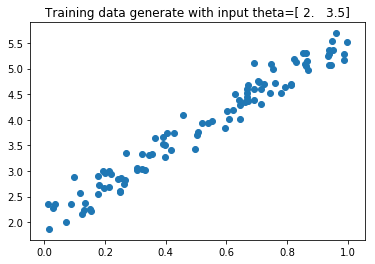

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

in_theta = np.array([2.0, 3.5])
sigma = .2
min_x = [0.]
max_x = [1.]
N = 100
data_X, data_y = create_dataset(in_theta, min_x, max_x, sigma, N)


vis.draw(data_X[:,1], data_y, title='Training data generate with input theta={}'.format(in_theta))

# split to train & validation
from sklearn.model_selection import train_test_split
train_X, val_X, train_y, val_y = train_test_split(data_X, data_y, test_size=0.2)

Let's implement the GD/SGD fitting to recover original $\theta$ from training data

In [9]:
class LinearRegressionModel(object):
    def __init__(self, learning_rate):
        self._learning_rate = learning_rate
        self._theta = None
    
    def _loss(self, batch_x, batch_y):
        '''
        compute mini-batch loss and derivative with respect to theta
        
        Input
        :param batch_x is ndarray of shape [batch_size, D+1]
        :param batch_y is ndarray of shape [batch_size]
        
        :return:
            loss: least-square loss function
            dloss/dtheta: derivative of loss with respect to theta
        '''
        assert (self._theta is not None)
                
        err = batch_x.dot(self._theta) - batch_y
        loss = 0.5 * np.sum(np.square(err))
        dtheta = np.transpose(batch_x).dot(err)
        
        return loss, dtheta
    
    def _step(self, batch_X, batch_y):
        loss, dtheta = self._loss(batch_X, batch_y)
        self._theta  = self._theta - self._learning_rate * dtheta
        return loss
    
    def get_batches(self, train_X, train_y, batch_size):
        # get number of sample and compute number of batches
        N = train_X.shape[0]
        nb_batches   = N // batch_size
        
        # shuffle training sample
        idx = np.arange(N)
        np.random.shuffle(idx)
        
        # return batch_x, batch_y
        for i in range(nb_batches):            
            batch_idx = idx[i*batch_size:(i+1) * batch_size]
            yield train_X[batch_idx], train_y[batch_idx]
            
    
    def fit(self, train_X, train_y, val_X, val_y,
            batch_size, epochs, debug = False):
        # get number of sample and input dimension
        N, input_dim = train_X.shape
        nb_batches   = N // batch_size
        # initialized by a random-normal
        self._theta = np.random.randn(input_dim)
        
        self._dbg_loss = None
        # if debug on, we store loss        
        if debug:
            self._dbg_loss = []
        # iteratively update theta        
        for e in range(epochs):            
            for batch_X, batch_y in self.get_batches(train_X, train_y, batch_size):
                loss = self._step(batch_X, batch_y)
                if debug:    
                    val_loss,_ = self._loss(val_X, val_y) 
                    self._dbg_loss.append([loss/batch_size, val_loss/val_X.shape[0]])
    
    def predict(self, x):
        assert (self._theta is not None)
        return x.dot(self._theta)

We can try to train our model on generated synthetic dataset

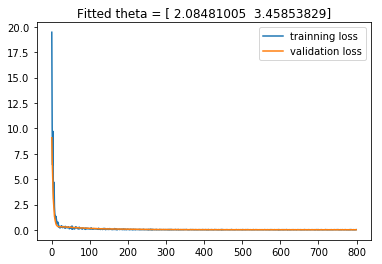

In [35]:
clf = LinearRegressionModel(learning_rate=0.01)

# hyper parameters
epochs = 100

batch_size = 10
clf.fit(train_X, train_y, val_X, val_y, batch_size, epochs, debug=True)

# plot loss function
train_val_loss = np.array(clf._dbg_loss)
nb_loss = train_val_loss.shape[0]
_= vis.draw(range(nb_loss), 
         train_val_loss, 
         title = 'Fitted theta = {}'.format(clf._theta),
         legends = ['trainning loss', 'validation loss'], plot_type = 'plot')


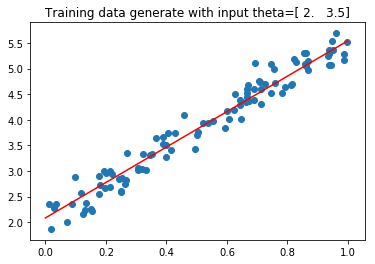

In [38]:
x_plot = np.linspace(min_x, max_x, 20)
fig_ax = vis.draw(data_X[:,1], data_y, plot_type='scatter')
_ = vis.draw(x_plot, x_plot * clf._theta[1] + clf._theta[0], fig_ax = fig_ax, 
         title = 'Training data generate with input theta={}'.format(in_theta),
         plot_type='plot', colors='r')


We can play around with various set of hyper-parameters `(batch_size, epochs, learning_rate)`, after trying various parameters one can notice the following
* the smaller batch_size the more noisy training loss, you can try batch_size = 5 for example
* the learning_rate for this dataset should be in [0.005, 0.1]
    * if the learning_rate is small e.g 1e-3, the training need ~ 500 epochs to converge
    * if the learning_rate is big e.g 2e-1, the training will blow up

For this simple dataset, we find that batch_size=10, epochs=100 and learning_rate=1e-2 seems performing well.

## Conclusion
The linear regression is one of the most simple learning algorithm, but it's still very popular since it's very fast to train and its result is very easy to interpret. In this notebook, we have learnt to fit linear regression using Stochastic Gradient Descent, however in practice, we often use the closed-form for linear regression. We will discuss it in next part.